# Data analysis 

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter


df = pd.read_csv("COVID19_data.csv", index_col="ID")
df.head()

,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
ID,,,,,,,,,,,,
1,15.0,FEMALE,4,0,NO,NaN,37.0,0,0,92,0,0
2,18.0,FEMALE,4,0,NO,ADMISSION,37.3,105,0,97,0,0
3,21.0,MALE,7,0,NO,NaN,38.5,112,0,95,85,47
4,21.0,MALE,10,0,NO,ADMISSION,39.2,113,0,97,0,0
5,22.0,MALE,4,0,NO,NaN,36.3,80,0,92,111,70


In [196]:
df.shape

(2054, 12)

## Analysis 

### High level statistics

In [197]:
df.describe()

,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,2050.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000
mean,70.856585,8.118793,0.355404,28.386319,70.787731,1.776047,73.397760,83.571568,48.328140
std,20.456931,6.177872,2.173721,15.419158,41.802038,20.434622,37.863716,67.450853,44.225438
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,4.000000,0.000000,35.400000,63.000000,0.000000,81.000000,0.000000,0.000000
50%,68.000000,7.000000,0.000000,36.400000,84.000000,0.000000,93.000000,115.000000,64.000000
75%,98.000000,10.000000,0.000000,36.900000,98.000000,0.000000,96.000000,137.000000,79.000000
max,189.000000,98.000000,36.000000,40.100000,593.000000,448.000000,99.000000,772.000000,845.000000


Glucose is directly removed as is has fewer than 25% non-zero values

In [198]:
df.pop('GLUCOSE')

ID
1       0
2       0
3       0
4       0
5       0
       ..
2050    0
2051    0
2052    0
2053    0
2054    0
Name: GLUCOSE, Length: 2054, dtype: int64

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 1 to 2054
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              2050 non-null   float64
 1   SEX              2052 non-null   object 
 2   DAYS_HOSPITAL    2054 non-null   int64  
 3   DAYS_ICU         2054 non-null   int64  
 4   EXITUS           2013 non-null   object 
 5   DESTINATION      671 non-null    object 
 6   TEMP             2054 non-null   float64
 7   HEART_RATE       2054 non-null   int64  
 8   SAT_O2           2054 non-null   int64  
 9   BLOOD_PRES_SYS   2054 non-null   int64  
 10  BLOOD_PRES_DIAS  2054 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 192.6+ KB


### Unvriate analysis

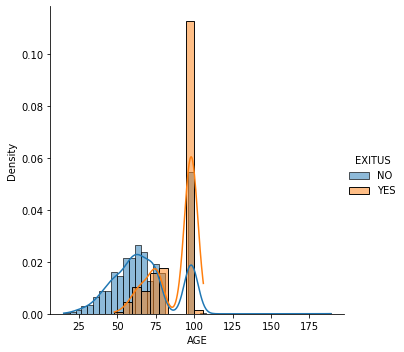

In [200]:
sns.FacetGrid(df, hue ="EXITUS", height=5).map(sns.histplot, "AGE", kde=True, stat="density").add_legend()

In [201]:
df.AGE.value_counts()

98.0     574
77.0     140
74.0     105
72.0      94
57.0      77
        ... 
15.0       1
18.0       1
30.0       1
25.0       1
189.0      1
Name: AGE, Length: 62, dtype: int64

Since there are many values of success in the age of around 100, in particular 98, which does not make much sense, these values are eliminated

In [202]:
df = df[df["AGE"]<98]

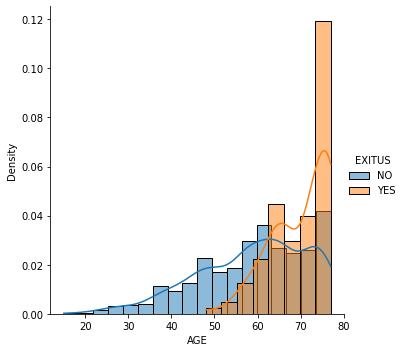

In [203]:
sns.FacetGrid(df, hue ="EXITUS", height=5).map(sns.histplot, "AGE", kde=True, stat="density").add_legend()

In [204]:

"""
var = ["DAYS_HOSPITAL","DAYS_ICU","TEMP","HEART_RATE","gl","SAT_O2","BLOOD_PRES_SYS","BLOOD_PRES_DIAS"]
for elem in var:
    g = sns.FacetGrid(df, hue ="EXITUS", height=5)
    g.map(sns.distplot, elem)
    g.add_legend()  
"""

'\nvar = ["DAYS_HOSPITAL","DAYS_ICU","TEMP","HEART_RATE","gl","SAT_O2","BLOOD_PRES_SYS","BLOOD_PRES_DIAS"]\nfor elem in var:\n    g = sns.FacetGrid(df, hue ="EXITUS", height=5)\n    g.map(sns.distplot, elem)\n    g.add_legend()  \n'

### Multivariate Analysis:

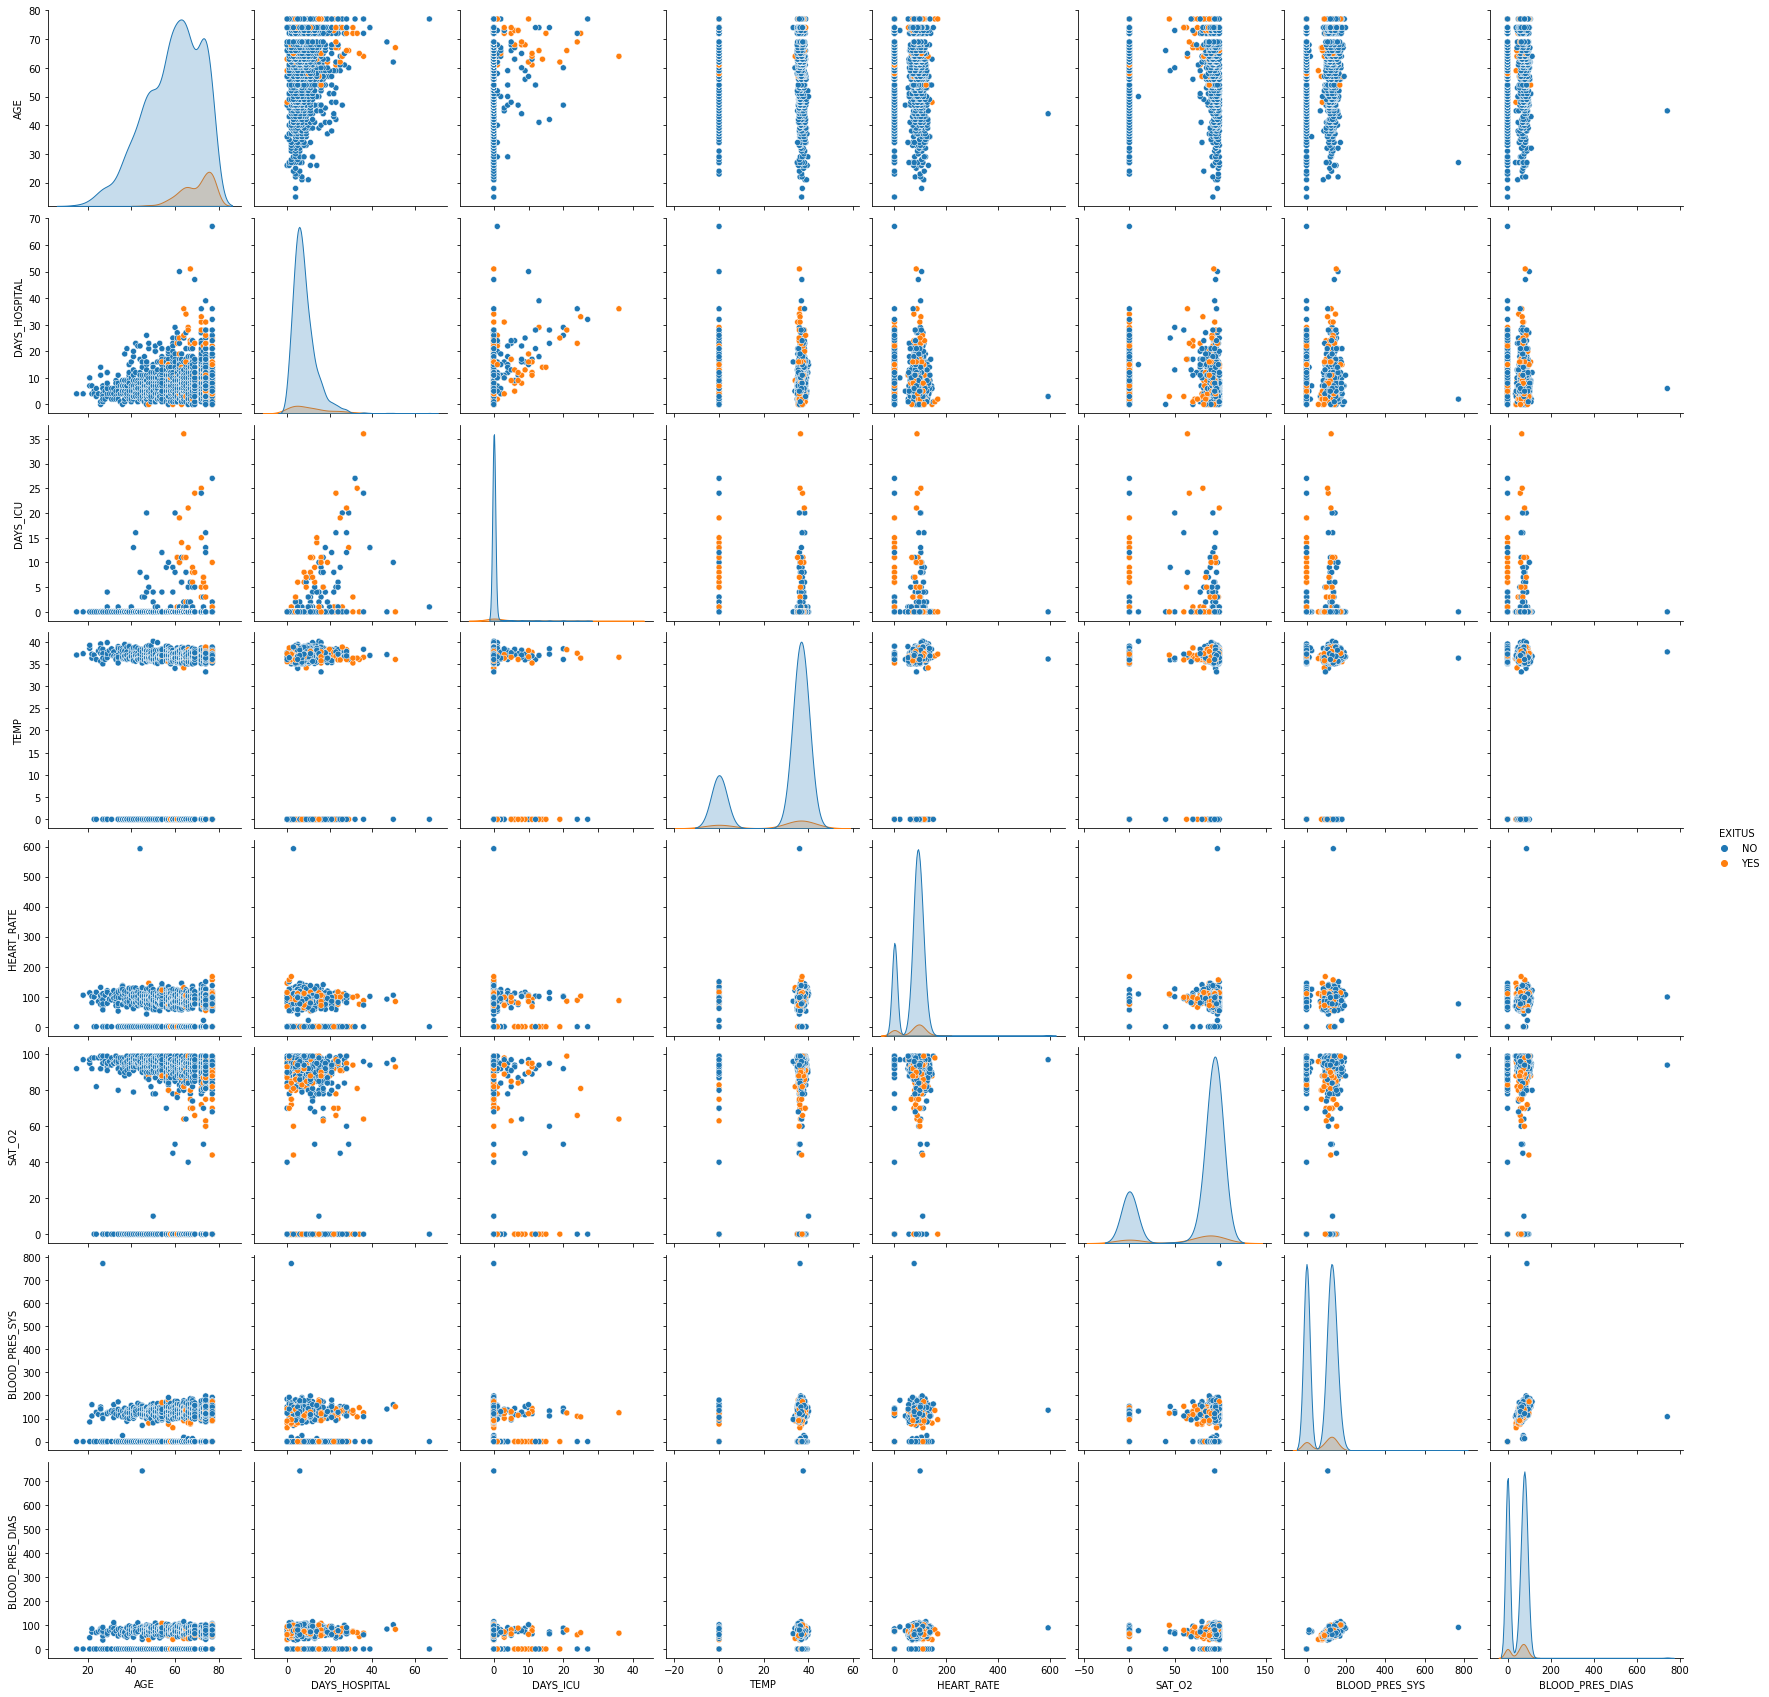

In [205]:
#pairplot
sns.pairplot(df, hue="EXITUS", height=3) 
plt.show()

## Preprocessing

### Make all columns numeric 

In [206]:
df.dtypes

AGE                float64
SEX                 object
DAYS_HOSPITAL        int64
DAYS_ICU             int64
EXITUS              object
DESTINATION         object
TEMP               float64
HEART_RATE           int64
SAT_O2               int64
BLOOD_PRES_SYS       int64
BLOOD_PRES_DIAS      int64
dtype: object

In [207]:
def get_categorical_variables(df):
  return [var for var in df if df[var].dtypes == object]

def get_numerical_variables(df):  
  return [var for var in df if df[var].dtypes != object]

In [208]:
CAT_VARS = get_categorical_variables(df)
NUM_VARS = get_numerical_variables(df)
print('CATEGORICAL', CAT_VARS)
print('NUMERICAL', NUM_VARS)

CATEGORICAL ['SEX', 'EXITUS', 'DESTINATION']
NUMERICAL ['AGE', 'DAYS_HOSPITAL', 'DAYS_ICU', 'TEMP', 'HEART_RATE', 'SAT_O2', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS']


### Missing values in categorical variables

In [209]:
df[CAT_VARS].isnull().sum() 

SEX              2
EXITUS          30
DESTINATION    970
dtype: int64

### Ranges for valid values

In [210]:
metrics_limits = {
  'TEMP': (33,42),
  'AGE': (1,120),
  'HEART_RATE': (40, 200),
  'SAT_O2': (40, 100),
  'BLOOD_PRES_SYS': (10, 200),
  'BLOOD_PRES_DIAS': (10, 130)
}

def in_range(col, min_val, max_val):
  return (col >= min_val) & (col <= max_val)

In [211]:
print('Invalid values per variable')
for metric in metrics_limits:
  min_value, max_value = metrics_limits[metric]
  mask = ~in_range(df[metric], min_value, max_value)
  print(metric, mask.sum() - (df[metric] == 0.0).sum())
  df.loc[mask, metric] = 0.0

df.describe()

Invalid values per variable
TEMP 0
AGE 0
HEART_RATE 2
SAT_O2 1
BLOOD_PRES_SYS 1
BLOOD_PRES_DIAS 1


/home/fompe/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,59.935154,8.349488,0.453925,28.270171,71.840956,72.838225,79.147440,46.856655
std,12.716133,6.162256,2.498243,15.534632,41.150347,38.727529,64.966459,38.426620
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,4.000000,0.000000,35.300000,63.000000,82.000000,0.000000,0.000000
50%,62.000000,7.000000,0.000000,36.400000,85.000000,93.000000,111.000000,65.000000
75%,72.000000,11.000000,0.000000,37.000000,100.000000,96.000000,133.000000,80.000000
max,77.000000,67.000000,36.000000,40.100000,167.000000,99.000000,198.000000,114.000000


### Zero values in numerical variabless

In [212]:
from collections import Counter
for var in NUM_VARS:
  print(var, Counter(df[var])[0])

AGE 0
DAYS_HOSPITAL 18
DAYS_ICU 1375
TEMP 339
HEART_RATE 326
SAT_O2 318
BLOOD_PRES_SYS 566
BLOOD_PRES_DIAS 566


#### DESTINATION

In [213]:
df.DESTINATION.value_counts()

ADMISSION    495
Name: DESTINATION, dtype: int64

In [214]:
df['DESTINATION'].fillna(0, inplace=True)
df['DESTINATION'].replace('ADMISSION', 1, inplace=True)

/home/fompe/.local/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/fompe/.local/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Values of the variable EXITUS that are null are eliminated, since it is the variable to be predicted. 

In [215]:
df = df[df['EXITUS'].notna()]

#### Rest of variables 
Since the number of null elements in the rest of the variables is very small, these have the mean value.  

In [216]:
df['AGE'].fillna(df['AGE'].mean(), inplace=True)
df['SEX'].fillna(df['SEX'].mode()[0], inplace=True)

df.isnull().sum() 

AGE                0
SEX                0
DAYS_HOSPITAL      0
DAYS_ICU           0
EXITUS             0
DESTINATION        0
TEMP               0
HEART_RATE         0
SAT_O2             0
BLOOD_PRES_SYS     0
BLOOD_PRES_DIAS    0
dtype: int64

In [217]:
df.SEX.mode()

0    MALE
dtype: object

### Make categorical variables to numerical for the analisys

In [218]:
print(df.EXITUS.value_counts())
df.EXITUS.replace('NO',0, inplace=True)
df.EXITUS.replace('YES',1, inplace=True)

NO     1324
YES     111
Name: EXITUS, dtype: int64


In [219]:
print(df.SEX.value_counts())
df.SEX = df.SEX.replace('MALE',0)
df.SEX = df.SEX.replace('FEMALE',1)

MALE      910
FEMALE    525
Name: SEX, dtype: int64


/home/fompe/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Continuation of the analysis 

### Survival curves

Probability of survival vs Days on hospital

Text(0.5, 1.0, 'Kaplan-Meier curve')

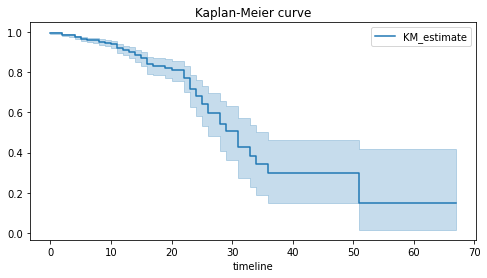

In [220]:
kmf = KaplanMeierFitter() 
kmf.fit(df['DAYS_HOSPITAL'], df['EXITUS'])
plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve")

Probability of survival vs Days on ICU

Text(0.5, 1.0, 'Kaplan-Meier curve')

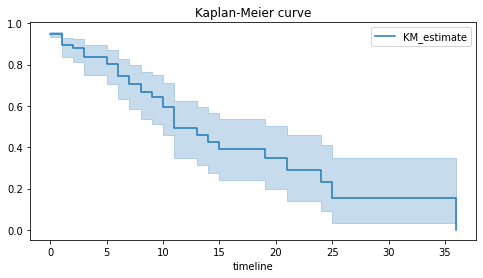

In [221]:
kmf.fit(df['DAYS_ICU'], df['EXITUS'])
plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve")

Probability of survival vs Patient's age

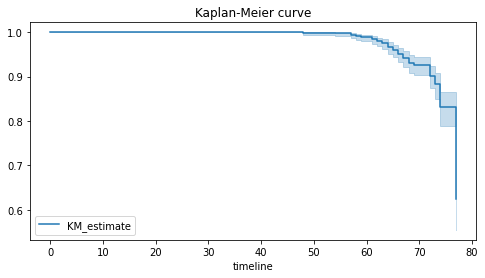

In [222]:
kmf.fit(df['AGE'], df['EXITUS'])
plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve");

### correlation matrix

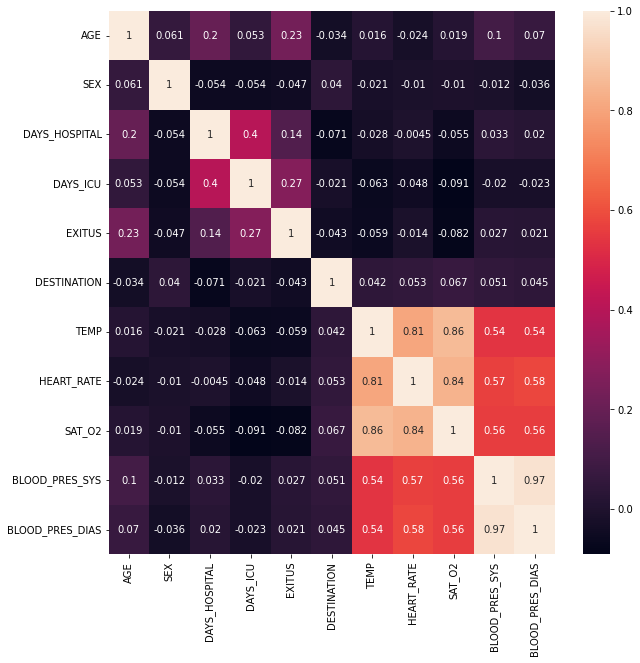

In [223]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True,  ax=ax)
plt.show()

### Dataset normalization

In [224]:
Y = df.EXITUS

In [225]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

X = df.drop(['EXITUS'], axis=1)

col_transformer = make_column_transformer(
    (OneHotEncoder(), ['SEX', 'DESTINATION']), 
    (MinMaxScaler(), NUM_VARS))

X = col_transformer.fit_transform(X)

In [226]:
X = pd.DataFrame(data=X)

# Clasification

In [227]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=4815)

### Regresión logistica 

In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LL = LogisticRegression()
LL.fit(X_train,y_train)
Y_pred_test = LL.predict(X_test)  
print(metrics.confusion_matrix(y_test,Y_pred_test))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred_test),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred_test),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred_test),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred_test),3)))

[[394   1]
 [ 36   0]]
Accuracy : 0.914
Precision : 0.0
Recall : 0.0
F1 : 0.0


### Decission Tree

In [229]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


param_dtree = {}
param_dtree ['max_depth'] = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150]

grid_dtree = GridSearchCV( DecisionTreeClassifier(), param_dtree, scoring='accuracy', cv=5, n_jobs=-1)
grid_dtree.fit(X_train, y_train)

results = pd.DataFrame(grid_dtree.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results

,params,mean_test_score,rank_test_score
0,{'max_depth': 3},0.924308,1
1,{'max_depth': 5},0.918333,2
2,{'max_depth': 10},0.911353,3
3,{'max_depth': 20},0.899403,4
4,{'max_depth': 30},0.897413,7
5,{'max_depth': 40},0.893413,13
6,{'max_depth': 50},0.894428,12
7,{'max_depth': 60},0.898408,6
8,{'max_depth': 70},0.895418,10
9,{'max_depth': 80},0.896403,9


In [230]:
clf = DecisionTreeClassifier( max_depth=3)
clf = clf.fit(X_train,y_train)

print(metrics.confusion_matrix(y_test,clf.predict(X_test)))
print("Accuracy: " + str(np.round(metrics.accuracy_score(y_test, clf.predict(X_test)),3)))
print("Precision: " + str(np.round(metrics.precision_score(y_test, clf.predict(X_test)),3)))
print("Recall: " + str(np.round(metrics.recall_score(y_test, clf.predict(X_test)),3)))
print("F1: " + str(np.round(metrics.f1_score(y_test, clf.predict(X_test)),3)))

[[389   6]
 [ 27   9]]
Accuracy: 0.923
Precision: 0.6
Recall: 0.25
F1: 0.353


### SVM

In [231]:
from sklearn.svm import SVC
SVM_res = SVC()
SVM_res.fit(X_train, y_train);
Y_pred = SVM_res.predict(X_test)
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[395   0]
 [ 36   0]]
Accuracy : 0.916
Precision : 0.0
Recall : 0.0
F1 : 0.0


/home/fompe/miniconda3/envs/env_PY/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [232]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train);
Y_pred = knn.predict(X_test)
    
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[393   2]
 [ 30   6]]
Accuracy : 0.926
Precision : 0.75
Recall : 0.167
F1 : 0.273


### Redes neuronales

In [233]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [234]:
EPOCHS = 20
def plot(h):
    LOSS = 0; ACCURACY=1
    training= np.zeros((2,EPOCHS)); testing= np.zeros((2, EPOCHS))
    training[LOSS]= h.history['loss']
    testing[LOSS]= h.history['val_loss']

    training[ACCURACY]= h.history['accuracy']
    testing[ACCURACY]= h.history['val_accuracy']

    epochs= range(1, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY), ('loss', 'accuracy')):
      axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
      axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
      axs[i].set_title('Training and Test '+ label)
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel(label)
      axs[i].legend()
    plt.show()

In [235]:
model = Sequential() 
model.add(Dense(50,input_dim = X_train.shape[1],activation='relu')) 
model.add(Dense(20,activation='relu')) 
model.add(Dense(5,activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=520, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 50)                650       
                                                                 
 dense_33 (Dense)            (None, 20)                1020      
                                                                 
 dense_34 (Dense)            (None, 5)                 105       
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2/2 [==============================] - 0s 97ms/step - loss: 0.6991 - accuracy: 0.4691 - val_loss: 0.6817 - val_accuracy: 0.6659
Epoch 2/20
2/2 [========================

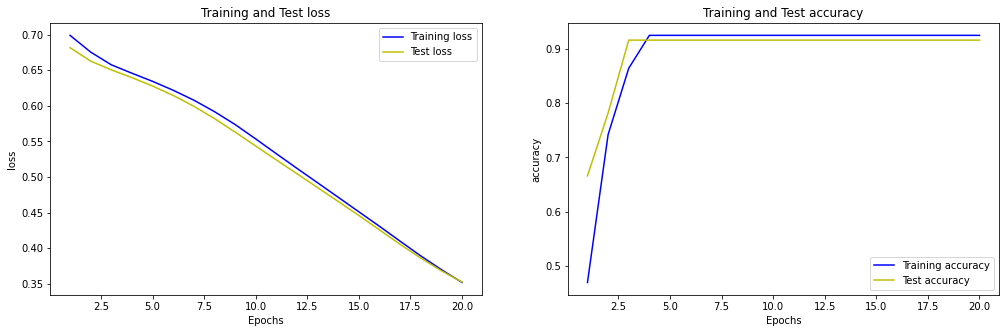

In [236]:
plot(history) 

## Modeling with same number of EXITUS=YES than EXITUS=NO

In [237]:
print(df.EXITUS.value_counts())


0    1324
1     111
Name: EXITUS, dtype: int64


In [238]:
from sklearn.utils import shuffle

dfreduced = df[df.EXITUS == 0].sample(111) 
dfreduced = pd.concat([dfreduced, df[df.EXITUS == 1]])
dfreduced = shuffle(dfreduced)

In [239]:
Y2 = dfreduced.EXITUS

In [240]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

X2 = dfreduced.drop(['EXITUS'], axis=1)

col_transformer = make_column_transformer(
    (OneHotEncoder(), ['SEX', 'DESTINATION']), 
    (MinMaxScaler(), NUM_VARS))

X2 = col_transformer.fit_transform(X2)

In [241]:
X2 = pd.DataFrame(data=X2)

In [242]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3, random_state=4815)

### Regresión logistica 

### Decission Tree

In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


param_dtree = {}
param_dtree ['max_depth'] = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150]

grid_dtree = GridSearchCV( DecisionTreeClassifier(), param_dtree, scoring='accuracy', cv=5, n_jobs=-1)
grid_dtree.fit(X_train, y_train)

results = pd.DataFrame(grid_dtree.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results

,params,mean_test_score,rank_test_score
0,{'max_depth': 3},0.716129,1
1,{'max_depth': 5},0.670968,3
2,{'max_depth': 10},0.664516,6
3,{'max_depth': 20},0.645161,13
4,{'max_depth': 30},0.664516,6
5,{'max_depth': 40},0.664516,6
6,{'max_depth': 50},0.677419,2
7,{'max_depth': 60},0.664516,6
8,{'max_depth': 70},0.658065,11
9,{'max_depth': 80},0.670968,3


In [244]:
clf = DecisionTreeClassifier( max_depth=3)
clf = clf.fit(X_train,y_train)

print(metrics.confusion_matrix(y_test,clf.predict(X_test)))
print("Accuracy: " + str(np.round(metrics.accuracy_score(y_test, clf.predict(X_test)),3)))
print("Precision: " + str(np.round(metrics.precision_score(y_test, clf.predict(X_test)),3)))
print("Recall: " + str(np.round(metrics.recall_score(y_test, clf.predict(X_test)),3)))
print("F1: " + str(np.round(metrics.f1_score(y_test, clf.predict(X_test)),3)))

[[25 10]
 [ 7 25]]
Accuracy: 0.746
Precision: 0.714
Recall: 0.781
F1: 0.746


### SVM

In [245]:
from sklearn.svm import SVC
SVM_res = SVC()
SVM_res.fit(X_train, y_train);
Y_pred = SVM_res.predict(X_test)
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[22 13]
 [ 8 24]]
Accuracy : 0.687
Precision : 0.649
Recall : 0.75
F1 : 0.696


### KNN

In [246]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train);
Y_pred = knn.predict(X_test)
    
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[29  6]
 [10 22]]
Accuracy : 0.761
Precision : 0.786
Recall : 0.688
F1 : 0.733


### Redes neuronales

In [247]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [248]:
EPOCHS = 50
def plot(h):
    LOSS = 0; ACCURACY=1
    training= np.zeros((2,EPOCHS)); testing= np.zeros((2, EPOCHS))
    training[LOSS]= h.history['loss']
    testing[LOSS]= h.history['val_loss']

    training[ACCURACY]= h.history['accuracy']
    testing[ACCURACY]= h.history['val_accuracy']

    epochs= range(1, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY), ('loss', 'accuracy')):
      axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
      axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
      axs[i].set_title('Training and Test '+ label)
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel(label)
      axs[i].legend()
    plt.show()

In [249]:
model = Sequential() 
model.add(Dense(50,input_dim = X_train.shape[1],activation='relu')) 
model.add(Dense(20,activation='relu')) 
model.add(Dense(5,activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=10, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 50)                650       
                                                                 
 dense_37 (Dense)            (None, 20)                1020      
                                                                 
 dense_38 (Dense)            (None, 5)                 105       
                                                                 
 dense_39 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
16/16 [==============================] - 0s 10ms/step - loss: 0.7035 - accuracy: 0.4774 - val_loss: 0.6909 - val_accuracy: 0.5075
Epoch 2/50
16/16 [====================

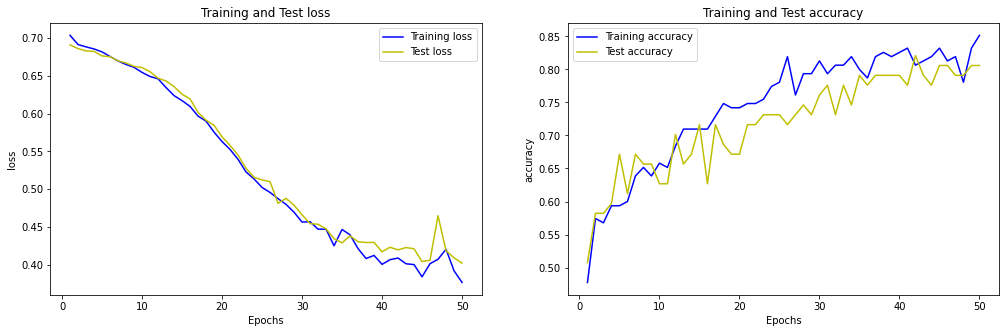

In [250]:
plot(history)